# Analysis figures for Transfer Learning model




The transfer learning model is a black-box CNN with inception, bidirectional, attention operators. 

Outputs from the CNN backbone is a vector, which is then linear-transformed to the same length of KINN intermediate rates, then added to the base rates as modifiers from sequence contexts.

$\delta_s =  f_{CNN}(seq) \cdot W +b$

$k = f_{KINN}(diff)$

$\hat{k} = k + \delta_s$


$\hat{k}_{eff} = KingAltman(\hat{k})$

$k_{eff} = KingAltman(k)$

Its effect, $\delta_s$, to the final model output $\hat{k}_{eff}$ is conditional on the base KINN intermediate kinetic rates $k$.

Therefore, it makes more sense to analyze the intermediate rate modifiers $\delta_s$, as outputed by CNN backbone, instead of the final KINN outputs $\hat{k}_{eff}$, and when $\delta_s$ is big enough such that $|\hat{k}_{eff} - k_{eff}| > \epsilon$.


In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import shap
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
from src.reload import reload_from_dir
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
%matplotlib inline

Using TensorFlow backend.


In [3]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------
controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager


2022-11-18 04:31:18,344 - AMBER - INFO -
 time budget set to: 72:00:00


env_type = ControllerTrainEnv


In [4]:
# I'll make this hard-coded for now for faster reproducibility
# for how this table is generated, see `11-TL_model_analysis-Valid_v_Test.ipynb`
benchmark_df = pd.read_table("./outputs/analysis/transfer_learn.incremental_benchmark.tsv")
benchmark_df

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,step,n_models,indv_perform,arc,trial,wd
0,0.188933,0.140707,0.208201,0.437008,0,1,"[0.189, 0.141, 0.208]","[0, 1, 5, 0, 0, 0, 1]",480,outputs/2022-11-01/TL_5
1,0.324715,0.195480,0.278344,0.439494,1,2,"[0.287, 0.188, 0.304]","[0, 2, 5, 0, 0, 0, 5]",494,outputs/2022-11-01/TL_3
2,0.316479,0.228706,0.352824,0.442244,2,3,"[0.242, 0.122, 0.247]","[1, 1, 5, 1, 1, 0, 5]",484,outputs/2022-11-01/TL_2
3,0.325627,0.222703,0.301412,0.442706,3,4,"[0.225, 0.127, 0.146]","[1, 2, 5, 0, 1, 0, 1]",494,outputs/2022-11-01/TL_1
4,0.364205,0.261566,0.324285,0.445176,4,5,"[0.186, 0.119, 0.171]","[0, 1, 1, 2, 1, 0, 3]",481,outputs/2022-11-01/TL_4


In [5]:
# load models
model_ensemble = []
for _, row in tqdm(benchmark_df.iterrows(), total=len(benchmark_df)):
    arc_seq = eval(row['arc'])
    target_wd = row['wd']
    best_trial_id = row['trial'] 
    #print(type(arc_seq))
    model = amb.model_fn(arc_seq)
    model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    model_ensemble.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
# load data
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()]
    kin_data = store["kinetic/x"][()], store["kinetic/y"][()], store["kinetic/k"][()]

data_cache = {
    'kleinsitver': t1,
    'listgarten': t2,
    'listgarten_indel': t3,
    'valid': valid_data,
    'kinetic': kin_data
}

In [7]:
y_pred = model_ensemble[-1].predict(t1[0], batch_size=25000)

In [8]:
y_pred2 = model_ensemble[0].predict(t1[0], batch_size=25000)

In [9]:
ss.spearmanr(y_pred, y_pred2)

SpearmanrResult(correlation=0.5627292367738634, pvalue=0.0)

In [10]:
model = model_ensemble[0]

In [11]:
# get each model's intermediate layer results
def get_intermediate_kinetic_model(model, include_kinn=True):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    # kinetic model: get intermediate outputs, e.g. predicted cleavage rate, seq delta, etc.
    kinetic_model = tf.keras.models.Model(
        inputs = model.inputs,
        outputs = [layer_dict[k_layer_name].output, layer_dict[k_layer_name].lin_transform.output] if include_kinn \
        else layer_dict[k_layer_name].lin_transform.output
    )
    return kinetic_model

def get_model_intermediate_outs(model, data):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    kinetic_model = get_intermediate_kinetic_model(model)
    # old_pred_ks: base KINN intermediate rates
    old_pred_ks = layer_dict[k_layer_name].kinn_header.predict(layer_dict[k_layer_name].mb.blockify_seq_ohe(data[:, :, 4:]))
    # pred_k: new cleavage rate
    # delta_seq: sequence delta
    pred_k, delta_seq = kinetic_model.predict(data)
    sess = tf.keras.backend.get_session()
    # old_pred_k: old cleavage_rate
    old_pred_k = sess.run(layer_dict[k_layer_name].kinn_body(old_pred_ks)).flatten()
    return {
        "old_ks": old_pred_ks,
        "old_clv": old_pred_k,
        "delta_seq": delta_seq,
        "new_ks": old_pred_ks + delta_seq,
        "new_clv": pred_k.flatten(),
    }


In [12]:
reload_res_from_disk = True
if reload_res_from_disk and os.path.isfile("./outputs/analysis/transfer_learning.model_intermediate.pkl"):
    with open("./outputs/analysis/transfer_learning.model_intermediate.pkl", "rb") as f:
        res = pickle.load(f)
else:
    res = {}
    for model_id in range(len(model_ensemble)):
        for data_id in data_cache:
            print(model_id, data_id)
            tmp = get_model_intermediate_outs(model=model_ensemble[model_id], data=data_cache[data_id][0])
            res[(model_id, data_id)] = tmp

    with open("./outputs/analysis/transfer_learning.model_intermediate.pkl", "wb") as f:
        pickle.dump(res, f)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


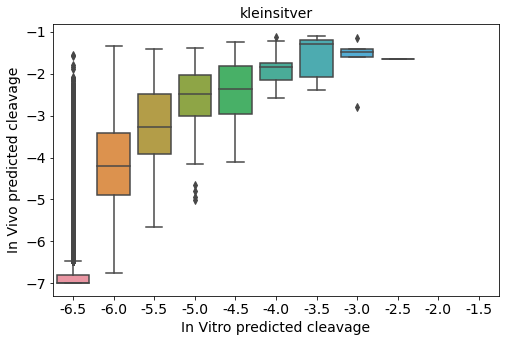

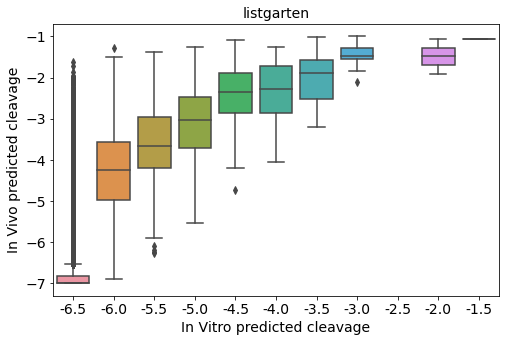

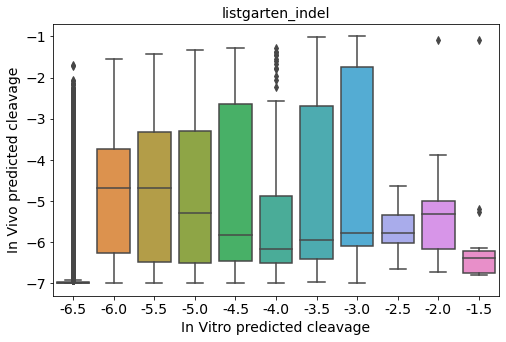

In [13]:
dfs = {}
for data_id in ['kleinsitver', 'listgarten', 'listgarten_indel']:
    in_vitro_clv = []
    in_vivo_clv = []
    for model_id in range(5):
        tmp = res[(model_id, data_id)]
        in_vitro_clv.append(tmp['old_clv'])
        in_vivo_clv.append(tmp['new_clv'])
    df = pd.DataFrame({
        'in_vitro_clv': np.array(in_vitro_clv).mean(axis=0), 
        'in_vivo_clv': np.array(in_vivo_clv).mean(axis=0)})
    df['in_vitro_clv_bin'] = pd.cut(df['in_vitro_clv'], [-7.1] + np.arange(-6.5, -1, 0.5).tolist())
    dfs[data_id] = df
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.boxplot(x='in_vitro_clv_bin', y='in_vivo_clv', data=df, ax=ax)
    _ = ax.set_xticklabels(np.arange(-6.5, -1, 0.5).tolist())
    ax.set_title(data_id)
    ax.set_xlabel('In Vitro predicted cleavage')
    ax.set_ylabel('In Vivo predicted cleavage')    

In [14]:
data_id = 'kleinsitver'
#data_id = 'listgarten'
#data_id = 'listgarten_indel'
dfs[data_id]['y_obs'] = data_cache[data_id][1]
diff_df = dfs[data_id].query("in_vitro_clv< -5 and in_vivo_clv> -2 and y_obs==1")
diff_df

,in_vitro_clv,in_vivo_clv,in_vitro_clv_bin,y_obs
95789,-5.553682,-1.763735,"(-6.0, -5.5]",1
95791,-5.753591,-1.636075,"(-6.0, -5.5]",1
95794,-5.356524,-1.774548,"(-5.5, -5.0]",1
95796,-5.196607,-1.906012,"(-5.5, -5.0]",1
95797,-5.715512,-1.848067,"(-6.0, -5.5]",1
95803,-6.625443,-1.551159,"(-7.1, -6.5]",1
95810,-5.305200,-1.387211,"(-5.5, -5.0]",1
95811,-5.172741,-1.750070,"(-5.5, -5.0]",1
95815,-5.055985,-1.504634,"(-5.5, -5.0]",1
95816,-6.894896,-1.888164,"(-7.1, -6.5]",1


In [15]:
# sanity check
from sklearn import metrics
print(
    metrics.average_precision_score(dfs[data_id]['y_obs'], dfs[data_id]['in_vivo_clv']),
    metrics.average_precision_score(dfs[data_id]['y_obs'], dfs[data_id]['in_vitro_clv']),
)

0.3616882263629 0.22789077430342408


In [16]:
def permute_seq(model, x):
    score = np.zeros((25,4))
    old = model.predict(x[np.newaxis, ...])
    for i in range(25):
        for j in range(4):
            _x = x.copy()
            _x[i, 0:4] = 0
            _x[i,j] = 1
            new = model.predict(_x[np.newaxis, ...])
            score[i,j] = new - old
    return score

"""
score = permute_seq(model, data_cache['kleinsitver'][0][diff_df.index[0]])
fig, ax = plt.subplots(1,1, figsize=(12,5))
rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
sns.heatmap(score.T, center=0, cmap=rdgn, ax=ax)
"""

"\nscore = permute_seq(model, data_cache['kleinsitver'][0][diff_df.index[0]])\nfig, ax = plt.subplots(1,1, figsize=(12,5))\nrdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)\nsns.heatmap(score.T, center=0, cmap=rdgn, ax=ax)\n"

In [17]:
def get_base_kinn_model(model):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    seq_ohe = model.inputs[0]
    seq_ohe = tf.gather(seq_ohe, layer_dict[k_layer_name].channels, axis=-1)
    inp_list = layer_dict[k_layer_name].mb.blockify_seq_ohe(seq_ohe)
    kinn_rates = layer_dict[k_layer_name].kinn_header(inp_list)
    clv = layer_dict[k_layer_name].kinn_body(kinn_rates)
    kinetic_model = tf.keras.models.Model(
        inputs = model.inputs,
        outputs = clv
    )
    return kinetic_model

In [18]:
def get_shap(model, kinn, x):
    bg_seq = np.zeros((1,25,13))
    e=shap.GradientExplainer(model, bg_seq, batch_size=25000)
    e2=shap.GradientExplainer(kinn, bg_seq, batch_size=25000)
    res = e.shap_values(X=x)
    res2 = e2.shap_values(X=x)
    diff = (res[0]/np.abs(res[0]).max()-res2[0]/np.abs(res2[0]).max()).squeeze().T
    diff = diff/np.abs(diff).max()
    return res[0], res2[0], diff

def get_diff_df(data_id):
    dfs[data_id]['y_obs'] = data_cache[data_id][1]
    diff_df = dfs[data_id].query("in_vitro_clv< -5 and in_vivo_clv> -2 and y_obs==1")
    diff_df['clv_diff'] = diff_df['in_vitro_clv'] - diff_df['in_vivo_clv']
    return diff_df.sort_values('clv_diff', ascending=True)



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import colors


def mat_to_seq(annot):
    letters = list('ACGT')
    seq_ohe = annot[:, 0:4]
    s = [letters[np.where(x)[0][0]] if np.sum(x)==1 else 'N' for x in seq_ohe]
    return s


def heatmap_with_circle(s, c, annot, remove_indel=False):
    N = 13 if remove_indel is False else 8
    M = 25
    letters = 'ACGT'
    ylabels = list(letters) + ['s-%s'%x for x in letters]
    if remove_indel: 
        s = s[0:8]
        c = c[0:8]
    else:
        ylabel +=  ['i-%s'%x for x in letters] + ['d']
    #xlabels = np.arange(1, M+1)
    xlabels = mat_to_seq(annot)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    #s = np.random.randint(0, 180, size=(N,M))
    #c = np.random.rand(N, M)-0.5

    fig, ax = plt.subplots(1,1,figsize=(12,5))

    R = s/s.max()/2
    circles = [plt.Circle((j,i), radius=r, alpha=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
    divnorm=colors.TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=0.5)
    col = PatchCollection(circles, array=c.flatten(), cmap=rdgn, norm=divnorm)
    ax.add_collection(col)

    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.grid(which='minor')

    fig.colorbar(col)
    plt.gca().invert_yaxis()
    return fig, ax

In [20]:
reload_shaps_from_disk = False
shaps = {}

for data_id in ['kleinsitver', 'listgarten', 'listgarten_indel']:
    diff_df = get_diff_df(data_id)
    for model_id, model in enumerate(model_ensemble):
        print(model_id)
        model = model_ensemble[model_id]
        kinn = get_base_kinn_model(model)
        for idx in tqdm(diff_df.index):
            x=data_cache[data_id][0][[idx]]
            res, res2, diff = get_shap(model, kinn, x)
            shaps[(model_id, data_id, idx)] = diff

with open('./outputs/analysis/transfer_learning.shaps.pkl', 'wb') as f:
    pickle.dump(shaps, f)

0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/12 [00:00<?, ?it/s]

1


  0%|          | 0/12 [00:00<?, ?it/s]

2


  0%|          | 0/12 [00:00<?, ?it/s]

3


  0%|          | 0/12 [00:00<?, ?it/s]

4


  0%|          | 0/12 [00:00<?, ?it/s]

invalid value encountered in true_divide

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0


  0%|          | 0/9 [00:00<?, ?it/s]

1


  0%|          | 0/9 [00:00<?, ?it/s]

2


  0%|          | 0/9 [00:00<?, ?it/s]

3


  0%|          | 0/9 [00:00<?, ?it/s]

4


  0%|          | 0/9 [00:00<?, ?it/s]

invalid value encountered in true_divide

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0


  0%|          | 0/8 [00:00<?, ?it/s]

1


  0%|          | 0/8 [00:00<?, ?it/s]

2


  0%|          | 0/8 [00:00<?, ?it/s]

3


  0%|          | 0/8 [00:00<?, ?it/s]

4


  0%|          | 0/8 [00:00<?, ?it/s]

invalid value encountered in true_divide


In [21]:
# concat shaps by datapoints
shaps_agg = {}
_shaps_agg = defaultdict(list)
for k, diff in shaps.items():
    model_id, data_id, idx = k
    if np.isnan(diff.sum()):
        continue
    _shaps_agg[(data_id, idx)].append(diff)

for k,v in _shaps_agg.items():
    tmp = np.array(_shaps_agg[k])
    shaps_agg[k] = tmp.mean(axis=0), 1/(tmp.var(axis=0)+0.1)

('listgarten', 383451)


<AxesSubplot:>

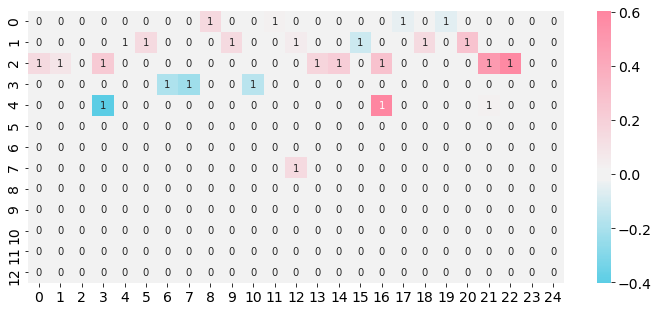

In [26]:
ks = [k for k in shaps_agg]
k = ks[16]
print(k)
x = data_cache[k[0]][0][k[1]]
fig, ax = plt.subplots(1,1, figsize=(12,5))
rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
sns.heatmap(shaps_agg[k][0], annot=x.squeeze().T, center=0, cmap=rdgn, ax=ax)

Text(0.5, 1.0, 'In Vivo=-1.26\nIn Vitro=-5.44')

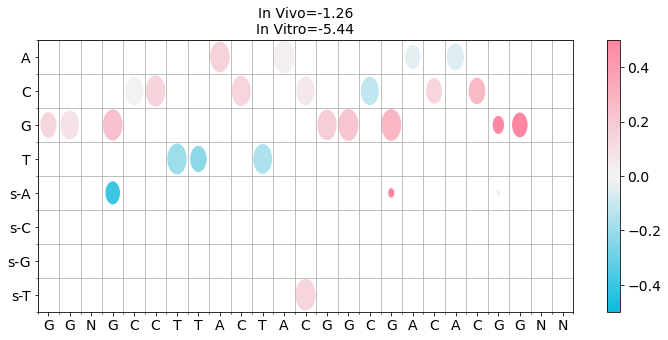

In [27]:
c = shaps_agg[k][0].copy()
c[c==0] = np.nan
s = shaps_agg[k][1]
annot = data_cache[k[0]][0][k[1]]
fig, ax = heatmap_with_circle(c=c, s=s, annot=annot, remove_indel=True)
ax.set_title("In Vivo=%.2f\nIn Vitro=%.2f" % (dfs[k[0]].loc[k[1], 'in_vivo_clv'], dfs[k[0]].loc[k[1], 'in_vitro_clv'], ))

Not used: bokeh bubble heatmap:

```python
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d, LinearColorMapper
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import RdBu


def bubble_heatmap(mean, vals, var=None):
    N = 25
    M = 13
    #output_file("label.html", title="label.py example")
    coords = np.array([[i,j] for i in range(N) for j in range(M)]).T
    var = np.ones_like(mean)*10 if var is None else var
    source = ColumnDataSource(data=dict(x=coords[0],
                                        y=coords[1],
                                        var=var.flatten(),
                                        mean=mean.flatten(),
                                        vals=vals.flatten()))
    colors = list(RdBu[9])
    exp_cmap = LinearColorMapper(palette=colors, 
                                 low = -1, 
                                 high = 1)

    p = figure(title='Dist. of 10th Grade Students at Lee High',
               x_range=Range1d(-2,N+1),
               y_range=Range1d(-2,M+1)
              )
    p.scatter(x='x', y='y', source=source, size="var",
             fill_color={"field":"mean", "transform":exp_cmap}
             )
    p.xaxis[0].axis_label = 'Basepair'
    p.yaxis[0].axis_label = 'SHAP values'

    labels = LabelSet(x='x', y='y', text='vals',
                  x_offset=0, y_offset=0, source=source, render_mode='canvas')


    p.add_layout(labels)
    show(p)

bubble_heatmap(mean=res.squeeze().T, vals=x.squeeze().T)
```

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Nov 18 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

h5py      : 2.10.0
scipy     : 1.7.3
src       : 0.0.3
seaborn   : 0.11.1
shap      : 0.41.0
tensorflow: 1.15.0
matplotlib: 3.4.3
pandas    : 1.0.3
sklearn   : 0.0
numpy     : 1.19.5

Watermark: 2.3.1

